# Отчёт по решению

Это описание решения на соревновании Kaggle "Предсказание победы в матчах по Dota2".

# SCORE 0.85243 ROC-AUC

## Содержание

### 1. Подготовка фичей
### 2. Предобработка
### 3. Модели

## 0. Подготовительные import и функции

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [64]:
def symmetric_stats_for_player(match_player):
    
    tot_dict={}
        
    r_kills = sum([match_player[i]["kills"] for i in range(5)])
    r_assists = sum([match_player[i]["assists"] for i in range(5)])
    r_deaths = sum([match_player[i]["deaths"] for i in range(5)])
    
    d_kills = sum([match_player[i]["kills"] for i in range(5,10)])
    d_assists = sum([match_player[i]["kills"] for i in range(5,10)])
    d_deaths = sum([match_player[i]["kills"] for i in range(5,10)])
    
    tot_dict['r_kda'] = (r_kills+r_assists)/max(1,r_deaths)
    tot_dict['d_kda'] =  (d_kills+d_assists)/max(1,d_deaths)
    tot_dict['diff_kda'] = tot_dict['r_kda'] -tot_dict['d_kda']
    return tot_dict

def additional_stats_for_player(match_player):
    kda=(match_player["kills"]+match_player["assists"])/max(match_player["deaths"],1)
    
    ability_size=len(match_player["ability_upgrades"]) 
    
    teamfight_participation=match_player["teamfight_participation"]
    
    ### purchase also is a time series with categorial
    purchases_neg=len([p for p in match_player['purchase_log'] if p['time']<0])
    purchases_pos=len([p for p in match_player['purchase_log'] if p['time']>=0])
    #purchases=match_player['purchase']
    ###
    
    #actions = match_player['actions']
    #gold_reasons
    
    ### These are dicts with specification
    killed_npc = sum([value for keys,value in match_player['killed'].items()])
    damage_npc = sum([value for keys,value in match_player['damage'].items()])
    damage_taken_npc = sum([value for keys,value in match_player['damage_taken'].items()])
    ###
    
    randomed = 1 if match_player['randomed'] else 0
    pred_vict = 1 if match_player['pred_vict'] else 0
    
    total_dict={
        'kda':kda,
        'damage_npc':damage_npc,
        'damage_taken_npc':damage_taken_npc,
        'killed_npc':killed_npc
    }
    
    return total_dict

mask = np.rot90(np.round(2*plt.imread("wardmap_mask.png"))/2,k=3).mean(axis=2)
def home_forein_sent(players):
    r_home_sen=0
    r_forein_sen=0

    d_home_sen=0
    d_forein_sen=0

    r_pos=[]
    for i in range(5):
        r_pos += players[i]['obs_log']+players[i]['sen_log']
    
    d_pos=[]
    for i in range(5,10):
        d_pos += players[i]['obs_log']+players[i]['sen_log']

    for i in range(len(r_pos)):
        x=r_pos[i]['x']
        y=r_pos[i]['y']
        marker=mask[x-64,y-64]
        if marker == 1:
            r_home_sen+=1
        elif marker == 0:
            r_forein_sen+=1

    for i in range(len(d_pos)):
        x=d_pos[i]['x']
        y=d_pos[i]['y']
        marker=mask[x-64,y-64]
        if marker == 0:
            d_home_sen+=1
        elif marker == 1:
            d_forein_sen+=1
            
    tot_dict={}
    #tot_dict["r_home_sen_p"] = r_home_sen/len(r_pos) if len(r_pos) != 0 else 
    tot_dict["r_forein_sen_p"] = r_forein_sen/len(r_pos) if len(r_pos) != 0 else 0
    #tot_dict["d_home_sen_p"] = d_home_sen
    tot_dict["d_forein_sen_p"] = d_forein_sen/len(d_pos) if len(d_pos) != 0 else 0
    #tot_dict["diff_home_sen"] = r_home_sen - d_home_sen
    tot_dict["diff_forein_sen_p"] = tot_dict["r_forein_sen_p"] - tot_dict["d_forein_sen_p"]
    
    return tot_dict


try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)
                
def dominance_time(t, arr_stat_r,arr_stat_d):
    if len(t) <2:
        return 0
    arr_stat_r_np = np.array(arr_stat_r)
    arr_stat_d_np = np.array(arr_stat_d)
    grid=np.linspace(0,1,num=5)
    outs_weights=np.array([0.125,0.25,0.25,0.25,0.125])

    if arr_stat_r_np[:,1].max() > arr_stat_d_np[:,1].max():
        T=t[1]
    else:
        T=-t[1]

    for i in range(2,len(t)):
        outs_r=(arr_stat_r_np[:,i-1][:,None]+arr_stat_r_np[:,i][:,None]*grid).max(axis=0)
        outs_d=(arr_stat_d_np[:,i-1][:,None]+arr_stat_d_np[:,i][:,None]*grid).max(axis=0)
        T+=(2*outs_weights[outs_r > outs_d].sum() - 1)*(t[i]-t[i-1])
    
    return T/t[-1]

def dominance_death(T,players,plot=False):
    deaths_r=[]
    deaths_d=[]
    T=T
    if T == 0:
        return 0

    for l in [players[i]['kills_log'] for i in range(5)]:
        for pos in l:
            deaths_r.append(pos['time']) 

    for l in [players[i]['kills_log'] for i in range(5,10)]:
        for pos in l:
            deaths_d.append(pos['time']) 

    deaths_d.sort()
    deaths_r.sort()
    
    deaths_r.append(T)
    deaths_d.append(T)
    
    if plot:
        plt.xlabel("time,s")
        plt.ylabel("Kills by team")
        plt.step(deaths_r,[i for i in range(len(deaths_r)-1)]+[len(deaths_r)-2],'b',where='post',label='radiant')
        plt.step(deaths_d,[i for i in range(len(deaths_d)-1)]+[len(deaths_d)-2],'r',where='post',label='dire')
        plt.show()
    
    death_count_r = [i for i in range(len(deaths_r)-1)]+[len(deaths_r)-2]
    death_count_d = [i for i in range(len(deaths_d)-1)]+[len(deaths_d)-2]
    
    l2 = [(t,'d') for t in deaths_d]
    l1 = [(t,'r') for t in deaths_r]
    l12 = sorted(l1+l2, key = lambda x: x[0])
    
    c=0
    dT=0
    for i in range(len(l12)):
        if i > 0 and c > 0:
            dT+=l12[i][0]-l12[i-1][0]
        elif i > 0 and c < 0:
            dT-=l12[i][0]-l12[i-1][0]
        
        if l12[i][1] == 'r':
            c+=1
        else:
            c-=1
            
    return dT/T

def add_purchases_team(players):
    purchase_list=[
'tpscroll',
 'ward_observer',
 'branches',
 'tango',
 'clarity',
 'ward_sentry',
 'boots',
 'ward_dispenser',
 'enchanted_mango',
 'flask',
 'magic_stick',
 'magic_wand',
 'blades_of_attack',
 'circlet',
 'stout_shield']
    
    tot_dict=defaultdict(int)
    
    for feat in purchase_list:
        for i in range(10):
            prefix = 'radiant_' if i < 5 else 'dire_'
            tot_dict[prefix+feat]+=players[i]['purchase'][feat] if feat in players[i]['purchase'].keys() else 0
        tot_dict['diff_'+feat]=tot_dict['radiant_'+feat]-tot_dict['dire_'+feat]
    return tot_dict


def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    id2player={0:'r1',1:'r2',2:'r3',3:'r4',4:'r5',5:'d1',6:'d2',7:'d3',8:'d4',9:'d5'}
    
    for match in read_matches(matches_file):
        
        #if match['game_time'] == 0:
        #    continue
        if match['game_time'] == 0:
            match['game_time']+=1
        
        
        match_id_hash = match['match_id_hash']
        r_kills=0
        r_assists=0
        r_deaths=0     
        d_kills=0
        d_assists=0
        d_deaths=0

        # Let us add new player specific features
        for i in range(10):
            #if i < 5:
            #    r_kills+=df_features.loc[match_id_hash,id2player[i]+'_kills']
            #    r_assists+=df_features.loc[match_id_hash,id2player[i]+'_assists']
            #    r_deaths+=df_features.loc[match_id_hash,id2player[i]+'_deaths']
            #else:
            #    d_kills+=df_features.loc[match_id_hash,id2player[i]+'_kills']
            #    d_assists+=df_features.loc[match_id_hash,id2player[i]+'_assists']
            #    d_deaths+=df_features.loc[match_id_hash,id2player[i]+'_deaths']
            
            
            match_player_feats = additional_stats_for_player(match['players'][i])
            for key,value in match_player_feats.items():
                player_key = id2player[i]+'_'+key
                df_features.loc[match_id_hash, player_key] = value
            
            
            symmetric_player_feats = symmetric_stats_for_player(match['players'])
            for key,value in symmetric_player_feats.items():
                df_features.loc[match_id_hash, key] = value
            
        time = match["players"][0]['times']
        
        arr_xp_r = [match["players"][i]['xp_t'] for i in range(5)]
        arr_xp_d = [match["players"][i]['xp_t'] for i in range(5,10)]
        
        arr_gold_r = [match["players"][i]['gold_t'] for i in range(5)]
        arr_gold_d = [match["players"][i]['gold_t'] for i in range(5,10)]
    
        df_features.loc[match_id_hash, "dominance_xp"] = dominance_time(time, arr_xp_r,arr_xp_d)
        df_features.loc[match_id_hash, "dominance_gold"] = dominance_time(time, arr_gold_r,arr_gold_d)
        df_features.loc[match_id_hash, "dominance_death"] = dominance_death(match["game_time"],match["players"])
        df_features.loc[match_id_hash, "dominance_ab_level"] = dominance_ability_level(match["game_time"],match["players"])
        
        for key,value in home_forein_sent(match["players"]).items():
            df_features.loc[match_id_hash, key]=value
            
        for key,value in add_purchases_team(match["players"]).items():
            df_features.loc[match_id_hash, key]=value
            
        ### Normalize feats
        #,'damage_npc','damage_taken_npc','killed_npc'
        for feat in ['gold','xp','health','max_health','max_mana','lh']:
            for i in range(10):
                #df_features.loc[match_id_hash, id2player[i]+'_'+feat+'_t']=df_features.loc[match_id_hash, id2player[i]+'_'+feat]/match["game_time"]
                df_features.loc[match_id_hash, id2player[i]+'_'+feat]/=match["game_time"]
                
        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
                    
        radiant_roshan_kills = 0
        dire_roshan_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
        #CHAT_MESSAGE_TOWER_DENY
        
        radiant_tower_denies = 0
        dire_tower_denies = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_DENY":
                if objective['player_slot'] in [128, 129, 130, 131, 132]:
                    radiant_tower_denies += 1
                if objective['player_slot'] in [0,1,2,3,4]:
                    dire_tower_denies += 1
                    
        # Посчитаем количество разрушенных казарм
        
        radiant_barracks_kills = 0
        dire_barracks_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                if int(objective["key"]) <= 2**5:
                    radiant_barracks_kills += 1
                else:
                    dire_barracks_kills += 1
                    
        feats_max=['health','max_health','max_mana']
        for feat in feats_max:
            r_max=max([match['players'][i][feat] for i in range(5)])
            d_max=max([match['players'][i][feat] for i in range(5,10)])
            diff=r_max-d_max
            df_features.loc[match_id_hash, "radiant_max_"+feat] = r_max/match["game_time"]
            df_features.loc[match_id_hash, "dire_max_"+feat] = d_max/match["game_time"]
            df_features.loc[match_id_hash, "diff_max_"+feat] = (r_max-d_max)/match["game_time"]
            
        df_features.loc[match_id_hash, "radiant_tower_denies"] = radiant_tower_denies
        df_features.loc[match_id_hash, "dire_tower_denies"] = dire_tower_denies
        df_features.loc[match_id_hash, "diff_tower_denies"] = radiant_tower_denies - dire_tower_denies
            
        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "radiant_barracks_kills"] = radiant_barracks_kills
        df_features.loc[match_id_hash, "dire_barracks_kills"] = dire_barracks_kills
        df_features.loc[match_id_hash, "diff_barracks_kills"] = radiant_barracks_kills - dire_barracks_kills
        
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_barracks_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_barracks_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_barracks_kills - dire_barracks_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
def plot_feature_importances(df, threshold = 0.9):

    N=50
    
    plt.rcParams['font.size'] = 12
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 15))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:N]))), 
            df['importance_normalized'].head(N), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:N]))))
    ax.set_yticklabels(df['feature'].head(N))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

## 1. Подготовка фичей

Признаки можно разделить на следующие группы:

1. Признаки принадлежащие игроку
2. Признаки принадлежащие команде в целом

Какие есть индивидуальные признаки изначально (в train_data.csv)?

In [5]:
PATH_TO_DATA = ""

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_features = reduce_mem_usage(df_train_features)

Memory usage of dataframe is 59.49 MB
Memory usage after optimization is: 11.37 MB
Decreased by 80.9%


В файле есть 5 признаков описывающих матч в целом ('game_time','game_mode','lobby_type','objectives_len','chat_len',)

Остальные 240 признаков это 24 признака на 10 игроков

Бейзлайн решение на этих признаках даёт 0,78 ROC-AUC. С помощью ансабля с CAT,LGBM и PCA на фичах это решение можно улучшить до 0.829

В чём проблема этих фичей? Эти фичи описывают конкретно игрока, а не команду и матч в целом, а используемые в отчёте модели (леса, линейные регрессии и т.п) недостаточно "глубокие" чтобы вытащить из разрозненных по игрокам признаков информацию о матче. К тому же, это очень сильно раздувает размерность признаков.

Поэтому где это возможно, мы будем вводить различные производные от персонализированных признаков, чтобы их сделать командными. Чаще всего это будут или командные суммы или командные максимумы.

Из большого jsona мы возьмём следующие фичи:

Индивидуальные:

- 'kda' -- индивидульный kda
- 'damage_npc' -- сумма значений в поле 'damage' у игрока
- 'damage_taken_npc' -- сумма значений в поле 'damage_taken' у игрока
- 'killed_npc' -- сумма значений в поле 'killed' у игрока

За их извлечение отвечает функция __additional_stats_for_player__ 

Командные фичи:

Простые:

- 'r_kda', 'd_kda', 'diff_kda' - командные KDA и их разница. Их извлекает __symmetric_stats_for_player__
- Для 15 наиболее популярных покупок среди игроков подсчитаем, сколько их в сумме взяла каждая команда и разницу сумм. Их исзвлекает __add_purchases_team__
- Подсчитаем из поля objectives в сумме по командам и разницу:
 - сколько разрушено башен ( "CHAT_MESSAGE_TOWER_KILL")
 - сколько убито Рошанов ("CHAT_MESSAGE_ROSHAN_KILL")
 - сколько разрушено казарм ("CHAT_MESSAGE_BARRACKS_KILL")
-  Также для параметров 'health','max_health','max_mana' вычислим командные максимумы и их разницу

Сложные:

#### Временные фичи

Рассмотрим фичи из временной шкалы. Это:

- match["players"][i]['xp_t'] -- опыт игрока в записанные моменты времени
- match["players"][i]['gold_t'] -- золото игрока в записанные моменты времени

Также вытащим из  match["players"][i]['kills_log'] серию моментов убийств других игроков. Нарисуем их графики, будут графики radiant, красным dire:

In [14]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl"),encoding='utf-8') as fin:
    # прочтем 419 строку
    for i in range(45):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

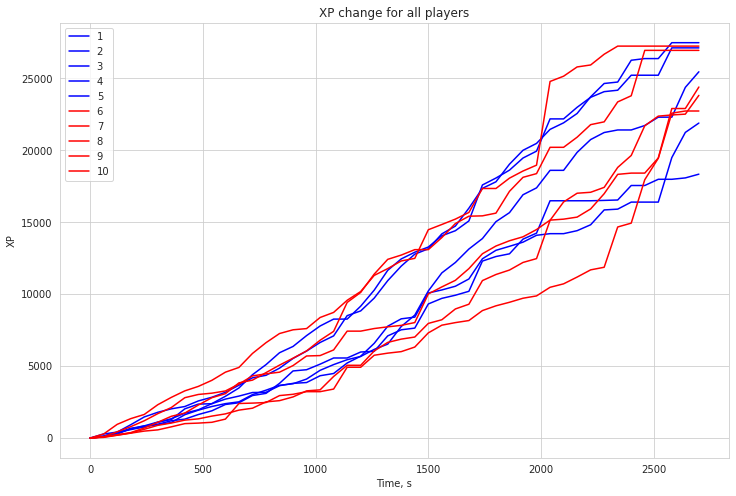

In [23]:
for i, player in enumerate(match["players"]):
    c='b' if i < 5 else 'r'
    plt.plot(player["times"], player["xp_t"], c,label=str(i+1))
#plt.plot(player["times"], player["xp_t"], 'g',label="sum_d")

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

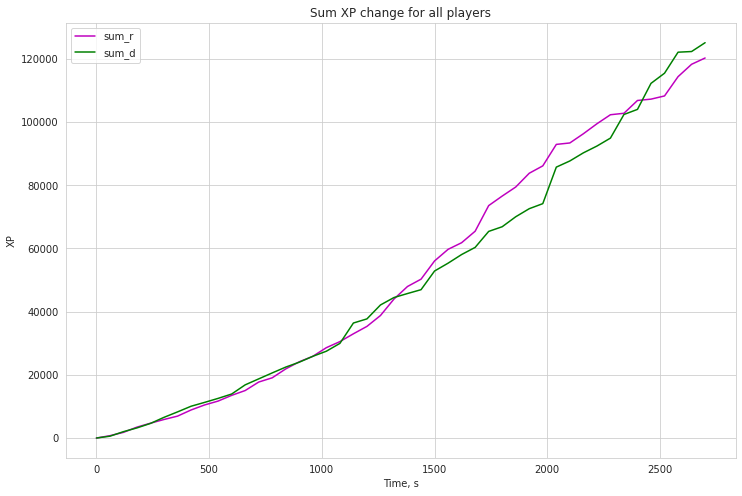

In [26]:
plt.plot(player["times"], np.array([player["xp_t"] for i,player in enumerate(match["players"]) if i < 5]).sum(axis=0), 'm',label="sum_r")
plt.plot(player["times"], np.array([player["xp_t"] for i,player in enumerate(match["players"]) if i >= 5]).sum(axis=0), 'g',label="sum_d")
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("Sum XP change for all players");
plt.show()

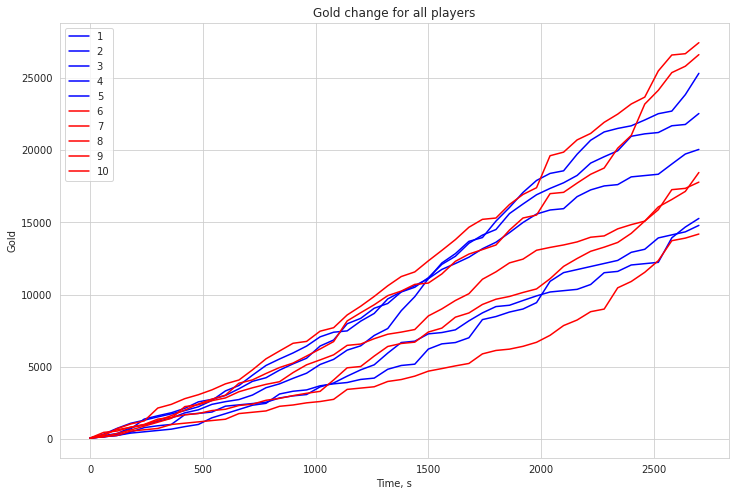

In [21]:
for i, player in enumerate(match["players"]):
    c='b' if i < 5 else 'r'
    plt.plot(player["times"], player["gold_t"], c,label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("Gold")
plt.title("Gold change for all players");

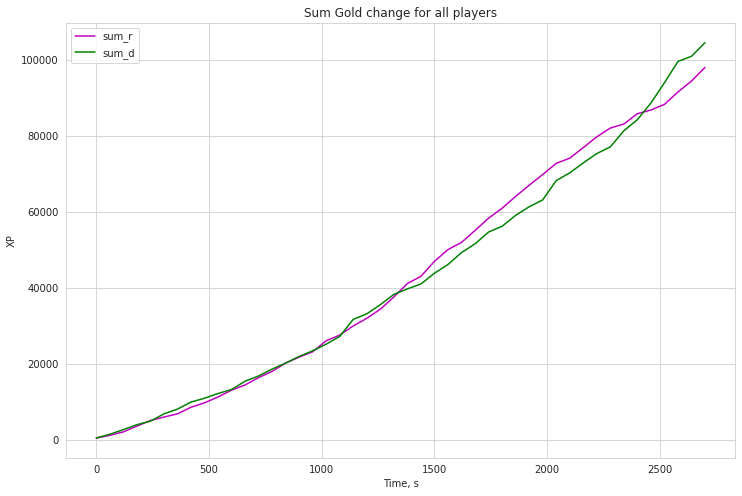

In [28]:
plt.plot(player["times"], np.array([player["gold_t"] for i,player in enumerate(match["players"]) if i < 5]).sum(axis=0), 'm',label="sum_r")
plt.plot(player["times"], np.array([player["gold_t"] for i,player in enumerate(match["players"]) if i >= 5]).sum(axis=0), 'g',label="sum_d")
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("Sum Gold change for all players");
plt.show()

Этот матч radiant проиграли, и как можно видеть максимум кривых достигался на красной линии, а не на синей. При этом, по командной сумме radiant и dire вели одинаковое количество времени, а по максимуму за dire увененное превосходство.

Суммарное количество убийств каждой командой

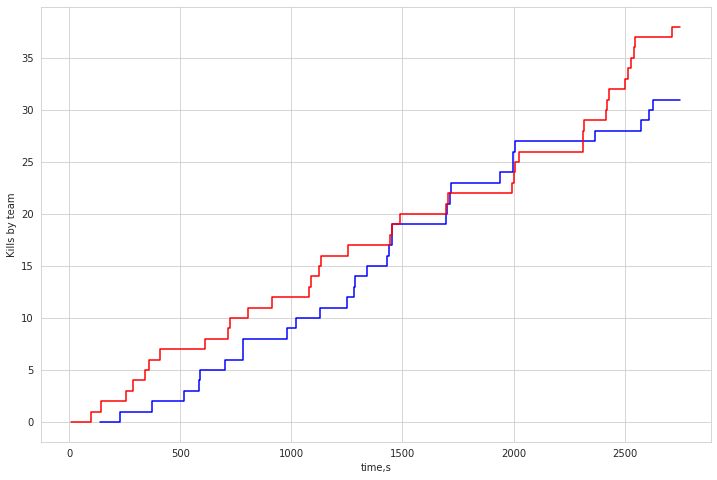

-0.5451836363636361

In [19]:
dominance_death(match['game_time'],match['players'],plot=True)

Для всех этих 3 графиков вычислим разность времени, когда максимум был за radiant и когда максимум был за dire.

#### Пространственные фичи

Из пространственных фич у нас есть координаты игроков и координаты поставленных wadrов

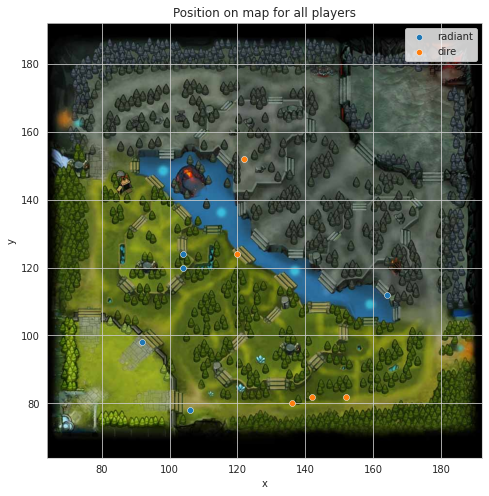

In [38]:
player_2_pos_r = [{'x':match['players'][i]['x'],'y':match['players'][i]['y']} for i in range(5)]
player_2_pos_d = [{'x':match['players'][i]['x'],'y':match['players'][i]['y']} for i in range(5,10)]
img = plt.imread("wardmap.jpg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[64, 192, 64, 192]) # log limits are 64 to 192.
ax = sns.scatterplot(x='x', y='y', data=pd.DataFrame.from_dict(player_2_pos_r), label='radiant' )
ax = sns.scatterplot(x='x', y='y', data=pd.DataFrame.from_dict(player_2_pos_d), label='dire')
plt.title("Position on map for all players");

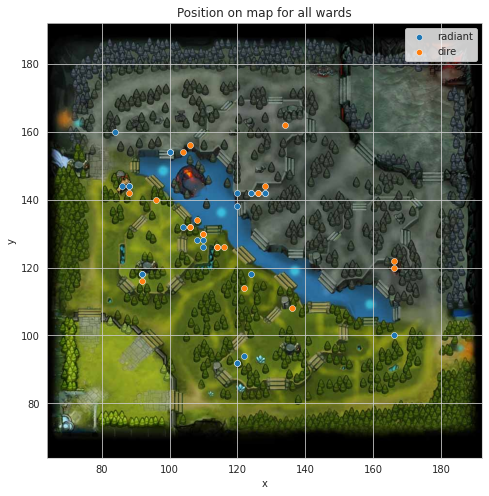

In [35]:
r_pos=[]
for i in range(5):
    r_pos += match['players'][i]['obs_log']+match['players'][i]['sen_log']
    
d_pos=[]
for i in range(5,10):
    d_pos += match['players'][i]['obs_log']+match['players'][i]['sen_log']
        
r_df = pd.DataFrame.from_dict(r_pos) 
r_df = r_df[["time", "x", 'y']] 

d_df = pd.DataFrame.from_dict(d_pos) 
d_df = d_df[["time", "x", 'y']]

img = plt.imread("wardmap.jpg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[64, 192, 64, 192]) # log limits are 64 to 192.
#sns.scatterplot(x='x', y='y', hue='home', data=d_df) 
sns.scatterplot(x='x', y='y',data=r_df,label='radiant')
sns.scatterplot(x='x', y='y',data=d_df,label='dire')
plt.title("Position on map for all wards");
# plt.show()

Анализировать эти координаты напрямую очень сложно, поэтому сделаем маску, чтобы различать точки на половине поля radiant, нейтральной и половине поля dire

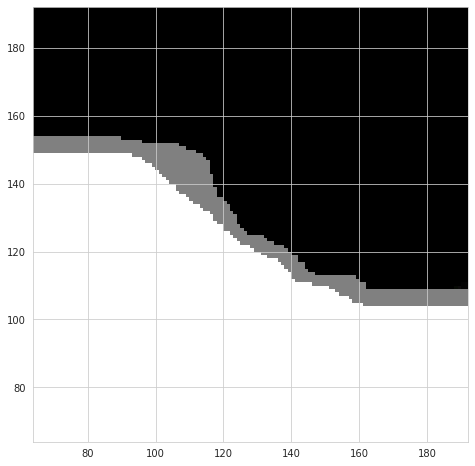

In [39]:
img = plt.imread("wardmap_mask.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[64, 192, 64, 192]) # log limits are 64 to 192.

По этой маске подсчитаем 2 статистики:

- Для каждого игрока команды поставим 1, если он находится на половине соперника, 0 если на нейтральной полосе и -1 если на своей. Просуммируем числа внутри команд и вычислим разность (radiant - dire) между командами. Если разность больше 0, то radiant преимущественно на половине соперника, если меньше 0, то наоборот.
- Вычислим разность долей вардов, которая поставили команды на чужой половине поля.

#### Имена героев

Изначально все герои (их 120 штук) просто закодированы их порядковым номером для каждого игрока. Наше решение состоит из решающих деревьев и лесов, и то, что герои упорядочены случайным образом сбивает модели с толку. Вместо этого, закодируем наборы героев "умным" one-hot векторами.

Введём 120 размерностей на каждого героя. Если в этом бою этот герой в команде radiant поставим 1, если он в команде dire, то -1, иначе 0.

## 2. Предобработка

Скачаем данные и извлечём фичи описанные выше

In [ ]:
PATH_TO_DATA = ""

df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

Их извлечение занимает минут 20, так что загрузим готовые признаки их csv

In [43]:
df_train_features_extended = reduce_mem_usage(pd.read_csv('backup_features-2022-03-25.csv',index_col='match_id_hash')).dropna()  

Memory usage of dataframe is 87.54 MB
Memory usage after optimization is: 19.59 MB
Decreased by 77.6%


Теперь, когда у нас загружены все признаки, перейдём к предобработке. Разделим все фичи на группы похожих по значениям (дискретные/непрерывные и большие/маленькие). Составим их списки:

In [41]:
purchase_list=[
'tpscroll',
 'ward_observer',
 'branches',
 'tango',
 'clarity',
 'ward_sentry',
 'boots',
 'ward_dispenser',
 'enchanted_mango',
 'flask',
 'magic_stick',
 'magic_wand',
 'blades_of_attack',
 'circlet',
 'stout_shield']
purchase_feats = [team+feat for team in ['radiant_','dire_','diff_'] for feat in purchase_list]
small_counts_feats=['radiant_tower_kills',
 'dire_tower_kills',
 'diff_tower_kills',
 'radiant_barracks_kills',
 'dire_barracks_kills',
 'diff_barracks_kills',
 'radiant_roshan_kills',
 'dire_roshan_kills',
 'diff_roshan_kills',
 #'radiant_tower_denies',
 #'dire_tower_denies',
 #'diff_tower_denies',
 'r_forein_sen_p',
 'd_forein_sen_p',
 'diff_forein_sen_p',
 'r_kda',
 'd_kda',
 'diff_kda']
dominance_feats=['dominance_xp',
 'dominance_gold',
 'dominance_death']
 #'dominance_ab_level']
game_feats=['game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len']

players=['r1','r2','r3','r4','r5','d1','d2','d3','d4','d5']
damage_feats = [t+'_'+c for t in players for c in ['damage_npc','damage_taken_npc','killed_npc']]
normalized_feats = [t+'_'+stat for t in players for stat in ['gold','lh','xp','health','max_health','max_mana']]+[team+feat for team in ['radiant_max_','dire_max_','diff_max_'] for feat in ['health','max_health','max_mana']]
hero_feats=[t+'_hero_id' for t in players]
player_count_list=['kills',
                  'deaths',
                  'assists',
                  'denies',
                  'level',
                  'stuns',
                  'creeps_stacked',
                  'camps_stacked',
                  'rune_pickups',
                  #'firstblood_claimed',
                  #'teamfight_participation',
                  #'towers_killed',
                  #'roshans_killed',
                  'obs_placed',
                  'sen_placed',
                  'kda']

player_cords = ['x','y']
player_count_feats=[t+'_'+c for t in players for c in player_count_list]
player_cords_feats=[t+'_'+c for t in players for c in player_cords]

Идея в том, чтобы для каждой группы в отедльности придумывать свой метод предобработки.

Для id героев, как писали выше, сделаем умные one-hot вектора

In [46]:
X_heroes = df_train_features_extended[hero_feats].values
X_hero_one_hot = np.zeros((X_heroes.shape[0], 121))
for i in range(X_heroes.shape[0]):
    X_hero_one_hot[i,X_heroes[i,:5]]+=1
    X_hero_one_hot[i,X_heroes[i,5:]]-=1
X_hero_one_hot = X_hero_one_hot[:,1:]

Остальные переменные разобьем на кучи согласно спискам фич

In [47]:
df_train_game_time = df_train_features_extended['game_time']
df_train_game_feats = df_train_features_extended[game_feats]
df_train_damage = df_train_features_extended[damage_feats] #PCA
df_train_count = df_train_features_extended[player_count_feats] #part sparse?
df_train_cords = df_train_features_extended[player_cords_feats] #PCA bad
df_train_hero = df_train_features_extended[hero_feats]
df_train_dominance = df_train_features_extended[dominance_feats] #PCA good with 1 comp
df_train_small_counts = df_train_features_extended[small_counts_feats] #sparse data 
df_train_purchase = df_train_features_extended[purchase_feats]  #sparse data
df_train_normalized = df_train_features_extended[normalized_feats] #PCA

X_time_n = df_train_game_time.values.reshape(-1,1)
X_game_n = df_train_game_feats.values
X_damage_n = df_train_damage.values
X_counts_n = df_train_count.values
X_cords_n = df_train_cords.values
X_hero_n = df_train_hero.values
X_dominance_n = df_train_dominance.values*X_time_n
X_small_counts_n = df_train_small_counts.values
X_purchase_n = df_train_purchase.values
X_normalized_n = df_train_normalized.values*X_time_n

Вычислим производные фичи от индивидуальных фич

In [48]:
X_c = X_counts_n.reshape(X_counts_n.shape[0],10,-1)
X_deriv_counts=X_c[:,:5,:].max(axis=1) - X_c[:,5:,:].max(axis=1)

Приведём переменную с координатами к статистике разностей присутствия на чужом поле, как писали выше

In [59]:
mask = np.rot90(np.round(2*plt.imread("wardmap_mask.png"))/2,k=3).mean(axis=2)
X_cords_n.reshape(-1,10,2)[0,1,:]
X_cords_reshape = X_cords_n.reshape(-1,10,2)-64
X_cord_forein_diff= ((2*np.round(2*mask[X_cords_reshape[:,:5,0],X_cords_reshape[:,:5,1]])-1).sum(axis=1) - (1-2*np.round(mask[X_cords_reshape[:,5:,0],X_cords_reshape[:,5:,1]])).sum(axis=1)).reshape(-1,1)

Теперь применим для некоторых групп фич PCA. Отбор этих групп происходил по следующему правилу: если после PCA первая объяснённая дисперсия сильно больше последующих, то применяем PCA. Иначе оставляем фичи как есть.

Запишем также имена новых переменных, чтобы отобразить feature importance модели

In [60]:
from sklearn.decomposition import PCA,TruncatedSVD,SparsePCA
from sklearn.preprocessing import StandardScaler

list_pca=[(X_game_n,None),(X_damage_n,None),(X_dominance_n,None),(X_small_counts_n,8),(X_normalized_n,None)]
pca_list=[]
prep_pca_base=[]


for raw_feat,n in list_pca:
    pca = PCA(n_components=n)
    pca.fit(raw_feat)
    prep_pca_base.append(pca.transform(raw_feat))
    pca_list.append(pca)
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.sum())
    
X_part_pca = np.hstack(prep_pca_base+[X_cord_forein_diff]+[X_purchase_n]+[X_counts_n]+[X_deriv_counts]+[X_hero_one_hot])
names_part_pca=[f'X_game_PCA_{i}' for i in range(X_game_n.shape[1])]+[f'X_gamage_PCA_{i}' for i in range(X_damage_n.shape[1])]
names_part_pca+=[f'X_dominance_PCA_{i}' for i in range(X_dominance_n.shape[1])]+[f'X_small_counts_PCA_{i}' for i in range(8)]
names_part_pca+=[f'X_normalized_PCA_{i}' for i in range(X_normalized_n.shape[1])]
names_part_pca+=['Cord_forein_diff']+purchase_feats+player_count_feats
names_part_pca+=['max_diff_'+feat for feat in player_count_list]
names_part_pca+=[f'hero_{i}' for i in range(120)]

[0.67225195 0.15409923 0.14054073 0.03310809]
1.0000000000000002
[0.57668084 0.05240112 0.04965556 0.04952191 0.0471664  0.04645525
 0.04588445 0.04507247 0.04284671 0.02054913 0.00280834 0.0018649
 0.00182593 0.00163243 0.00155135 0.00149062 0.00144859 0.00140852
 0.00135939 0.00129628 0.00123555 0.00070136 0.00067605 0.00067033
 0.00065261 0.00065169 0.0006434  0.00063144 0.00061307 0.00060426]
1.0
[0.61330986 0.25712395 0.12956613]
0.99999994
[0.41590309 0.26778897 0.20997593 0.06109295 0.02615395 0.01052884
 0.00681375 0.00174251]
0.9999999967191741
[8.3980602e-01 1.5572179e-02 1.5242298e-02 1.4982845e-02 1.4922945e-02
 1.4731813e-02 1.4574125e-02 1.4307937e-02 1.4097305e-02 1.3312922e-02
 7.2369692e-03 1.7540370e-03 1.6913336e-03 1.6810033e-03 1.6295724e-03
 1.5811408e-03 1.5539103e-03 1.5390898e-03 1.5126204e-03 1.3997324e-03
 9.1318792e-04 8.2733569e-04 3.3818578e-04 3.3519056e-04 3.3000219e-04
 3.2606567e-04 3.2042075e-04 3.1561367e-04 3.1040123e-04 3.0961682e-04
 2.9605761e-04

Проверим размерность объединённых признаков

In [52]:
X_part_pca.shape

(31698, 412)

Подгрузим таргеты обучающего набора

In [56]:
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

y = df_train_targets["radiant_win"].values.astype("int8")

In [57]:
y.shape

(31698,)

### 3. Модели

Из моделей можно взять что-нибудь с прошлого ноутбука. Лучше всего себя показывает CAT -- 0,8346 на кросс валидации, немного хуже LGBM -- 0,824. Для обеих моделей параметры подобраны гридсёрчем. Остальные модели показывают скор около 0,8 или хуже, так что они оставлены здесь только для справки. Обучим CAT классификатор и посмотрим на значимость фич.

In [61]:
%%time
from sklearn.model_selection import cross_validate

feature_importances = np.zeros(X_part_pca.shape[1])

cat = catboost.CatBoostClassifier(verbose=0,iterations=2000,max_depth=6,random_seed=SEED) # 1500-2000-5000 6 best 0.33 | 0.8206-0.8207
lgbm = lightgbm.LGBMClassifier(boosting_type='dart',max_depth=6,num_leaves=60,max_bin=50,random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
rf = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)

#models = [('CAT',cat),("LGBM",lgbm),("LGBM_RF",lgbm_rf),("XGB",xgb),('RF',rf),('LR',lr)]
models = [("CAT",cat)]

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

for name,model in models:
    cv_scores = cross_validate(model,X_part_pca, y, cv=cv, scoring="roc_auc",return_estimator=True)
    #print(cv_scores)
    feature_importances=np.array([p.feature_importances_ for p in cv_scores['estimator']])
    print(f"Среднее значение ROC-AUC {name} на кросс-валидации: {cv_scores['test_score'].mean()}")

Среднее значение ROC-AUC CAT на кросс-валидации: 0.8346729102328826
CPU times: user 29min 58s, sys: 30.7 s, total: 30min 28s
Wall time: 4min 24s


Построим графики значимости на основе усреднённых значимостей классификатора

In [62]:
feat_import = feature_importances.mean(axis=0)
feat_import = pd.DataFrame({'feature': names_part_pca, 'importance': feat_import}).sort_values('importance', ascending = False)

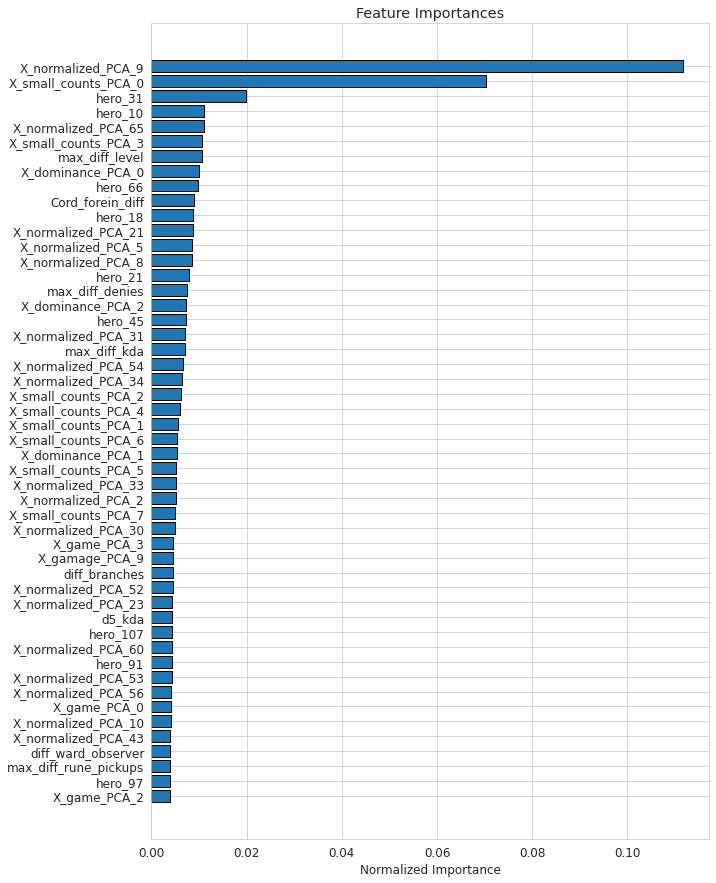

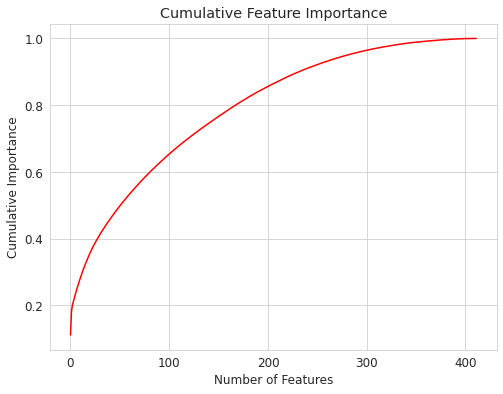

233 features required for 0.90 of cumulative importance


In [66]:
norm_feature_importances = plot_feature_importances(feat_import)

Как ни странно, попытки убрать из данных "выбросы": игры с нулевой длительностью или малозначительные фичи, приводили к ухудшению результата на тесте.

#### Cчитаем фичи для теста

In [ ]:
df_test_features = pd.read_csv(os.path.join("", "test_data.csv"), 
                                   index_col="match_id_hash")

df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

In [ ]:
X_heroes_test = df_test_features_extended[[t+'_hero_id' for t in players]].values
X_hero_test_one_hot = np.zeros((X_heroes_test.shape[0], 121))
for i in range(X_heroes_test.shape[0]):
    X_hero_test_one_hot[i,X_heroes_test[i,:5]]+=1
    X_hero_test_one_hot[i,X_heroes_test[i,5:]]-=1
X_hero_test_one_hot = X_hero_test_one_hot[:,1:]

df_test_game_time = df_test_features_extended['game_time']
df_test_game = df_test_features_extended[game_feats]
df_test_damage = df_test_features_extended[damage_feats] #PCA
df_test_count = df_test_features_extended[player_count_feats]
df_test_cords = df_test_features_extended[player_cords_feats] #PCA
df_test_hero = df_test_features_extended[hero_feats]
df_test_dominance = df_test_features_extended[dominance_feats] #PCA
df_test_small_counts = df_test_features_extended[small_counts_feats]
df_test_purchase = df_test_features_extended[purchase_feats]
df_test_normalized = df_test_features_extended[normalized_feats] #PCA

X_time_test = df_test_game_time.values.reshape(-1,1)
X_game_test = df_test_game.values
X_damage_test = df_test_damage.values
X_counts_test = df_test_count.values
X_cords_test = df_test_cords.values
X_hero_test = df_test_hero.values
X_dominance_test = df_test_dominance.values*X_time_test
X_small_counts_test = df_test_small_counts.values
X_purchase_test = df_test_purchase.values
X_normalized_test = df_test_normalized.values*X_time_test

X_cords_reshape_test = X_cords_test.reshape(-1,10,2)-64
X_cord_forein_diff_test= ((2*np.round(2*mask[X_cords_reshape_test[:,:5,0],X_cords_reshape_test[:,:5,1]])-1).sum(axis=1) - (1-2*np.round(mask[X_cords_reshape_test[:,5:,0],X_cords_reshape_test[:,5:,1]])).sum(axis=1)).reshape(-1,1)

X_c = X_counts_test.reshape(X_counts_test.shape[0],10,-1)
X_deriv_counts_test=X_c[:,:5,:].max(axis=1) - X_c[:,5:,:].max(axis=1)

list_pca_test=[X_game_test,X_damage_test,X_dominance_test,X_small_counts_test,X_normalized_test]
prep_pca=[]

for i in range(len(list_pca)):    
    prep_pca.append(pca_list[i].transform(list_pca_test[i]))
    
X_part_pca_test = np.hstack(prep_pca+[X_cord_forein_diff_test]+[X_purchase_test]+[X_counts_test]+[X_deriv_counts_test]+[X_hero_test_one_hot])

#### Сдаём результат

In [67]:
y_test_pred = cat.predict_proba(X_part_pca_test)[:, 1]

NameError: name 'X_part_pca_test' is not defined

In [ ]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))